# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [1]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sqlalchemy import create_engine

c:\Users\ruoxi\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Challenge 0 - Import a MySQL table into python:

In this lab, we will twist things up a little. Do you remember your good old friend SQL?
Well, it's time to bring him back and use it in our lab pipeline.

1º- Open the wholesale_customers_data.sql file in MySQL Workbench and run the script into a desired schema.

2º- Create a connection using sqlalchemy from python to mysql and load the table into a variable called *customers*

In [2]:
#Create a connection with create_engine to MySQL Workbench:
# First save my password in a container by using getpass
import getpass
saved_password = getpass.getpass()

In [3]:
# Import modules
import pymysql

# Connect to the database
connection = pymysql.connect(user = 'root',  port=3306,
                         password=saved_password,
                         db='wholesale')

# create cursor
cursor=connection.cursor()

In [4]:
# Execute Query
cursor.execute("SELECT * from wholesale_customers_data")

# Fetch the records
result = cursor.fetchall()

query = f"DESCRIBE {'wholesale_customers_data'}"
cursor.execute(query)
# Fetch the column names
column_names = [column[0] for column in cursor.fetchall()]

print(column_names)



['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']


In [5]:
customers = pd.DataFrame(result, columns=column_names)

In [6]:
customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [7]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [8]:
customers.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [9]:
'''To answer some of the questions in the checklist in challenge 1, here we can see there's no missing values and all the data are in integer datatype'''

"To answer some of the questions in the checklist in challenge 1, here we can see there's no missing values and all the data are in integer datatype"

In [10]:
# Close the connection
connection.close()

# Challenge 1 - Describe the Dataset

Your already loaded dataset contains information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

In case of curiosity, the origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [11]:
# Your code here:
# Check the unique values in "Channel" and "Region" as the describe result shows very small standard deviation
display(customers['Channel'].value_counts(), customers['Region'].value_counts())

Channel
1    298
2    142
Name: count, dtype: int64

Region
3    316
1     77
2     47
Name: count, dtype: int64

In [12]:
'''So Channel is more like a binary varibale, and Region only contains 3 different values. In the analysis, they should be considered as categorical values. Need to do one-hot encoding later'''

'So Channel is more like a binary varibale, and Region only contains 3 different values. In the analysis, they should be considered as categorical values. Need to do one-hot encoding later'

In [13]:
customers.columns

Index(['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen'],
      dtype='object')

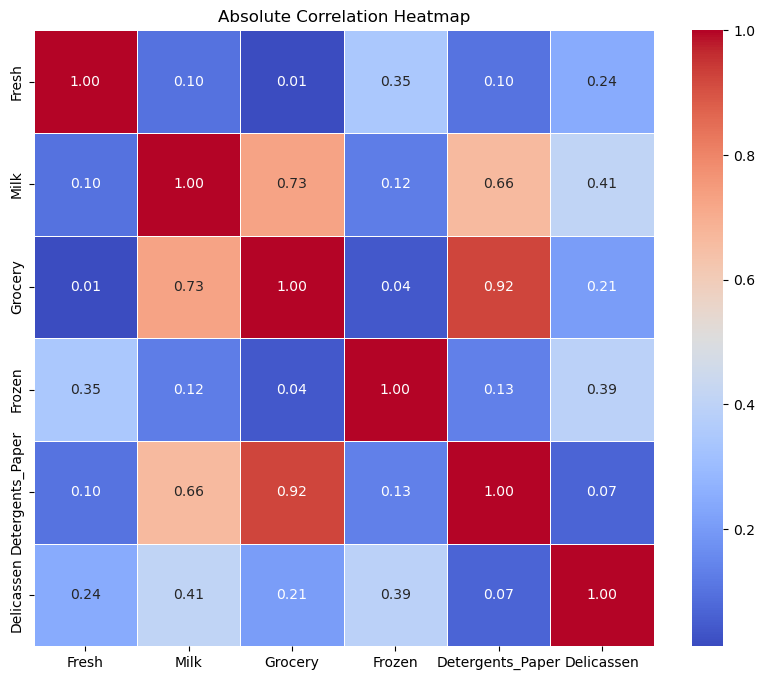

In [14]:
# Heatmap to check the collinearity
import seaborn as sns
numeric_columns = ['Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen']
# Calculate the correlation matrix
correlation_matrix = customers[numeric_columns].corr().abs()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Absolute Correlation Heatmap')
plt.show()

In [15]:
# Your observations here
'''Variable "Grocery" and  " Detergents_Paper" have very high correlation, over 0.9, which means one of them might need to be excluded from fitting the model'''

'Variable "Grocery" and  " Detergents_Paper" have very high correlation, over 0.9, which means one of them might need to be excluded from fitting the model'

c:\Users\ruoxi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


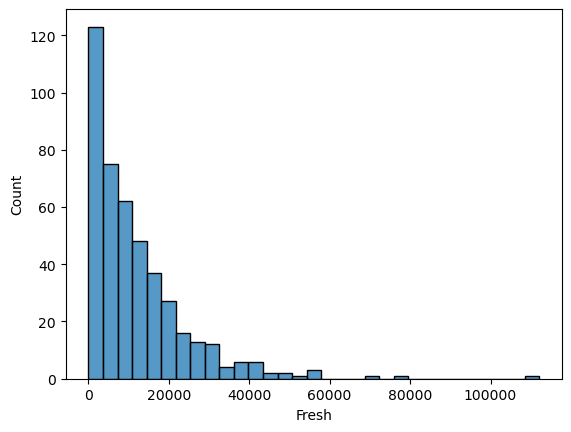

c:\Users\ruoxi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


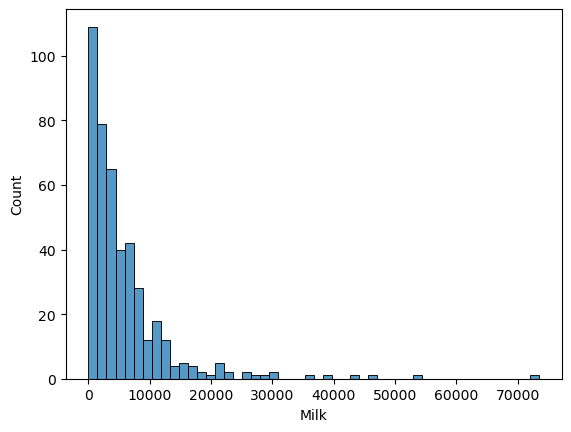

c:\Users\ruoxi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


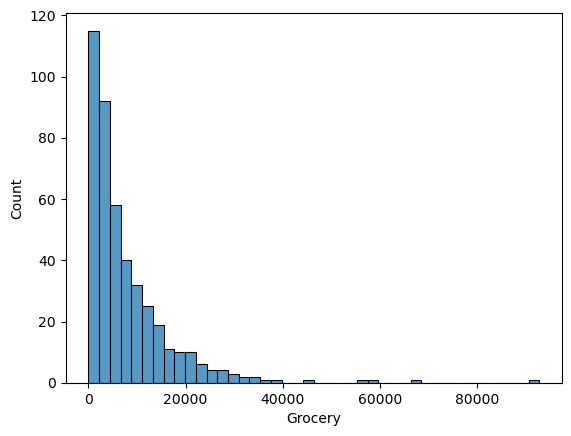

c:\Users\ruoxi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


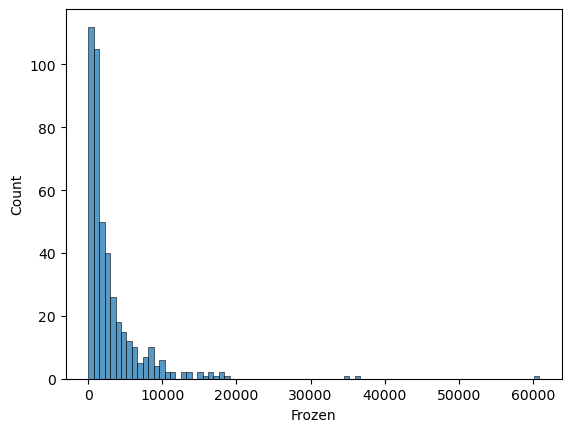

c:\Users\ruoxi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


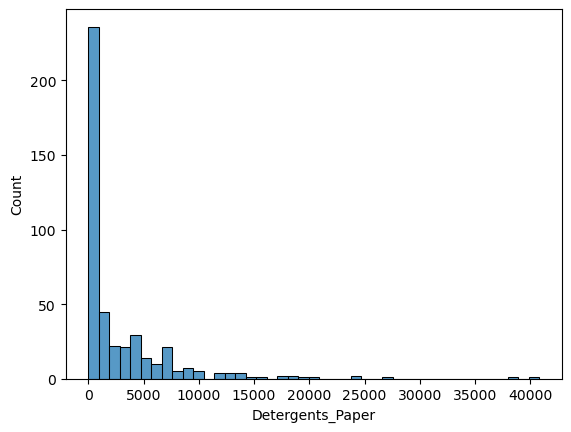

c:\Users\ruoxi\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


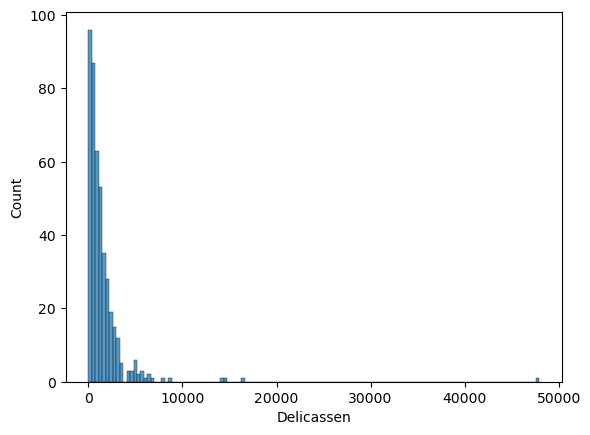

In [16]:
# User histogram to see the data distribution 
for column in numeric_columns:
    sns.histplot(customers[column])
    plt.xlabel(column)
    plt.show()

In [17]:
'''Data are heavily positively skewed '''

'Data are heavily positively skewed '

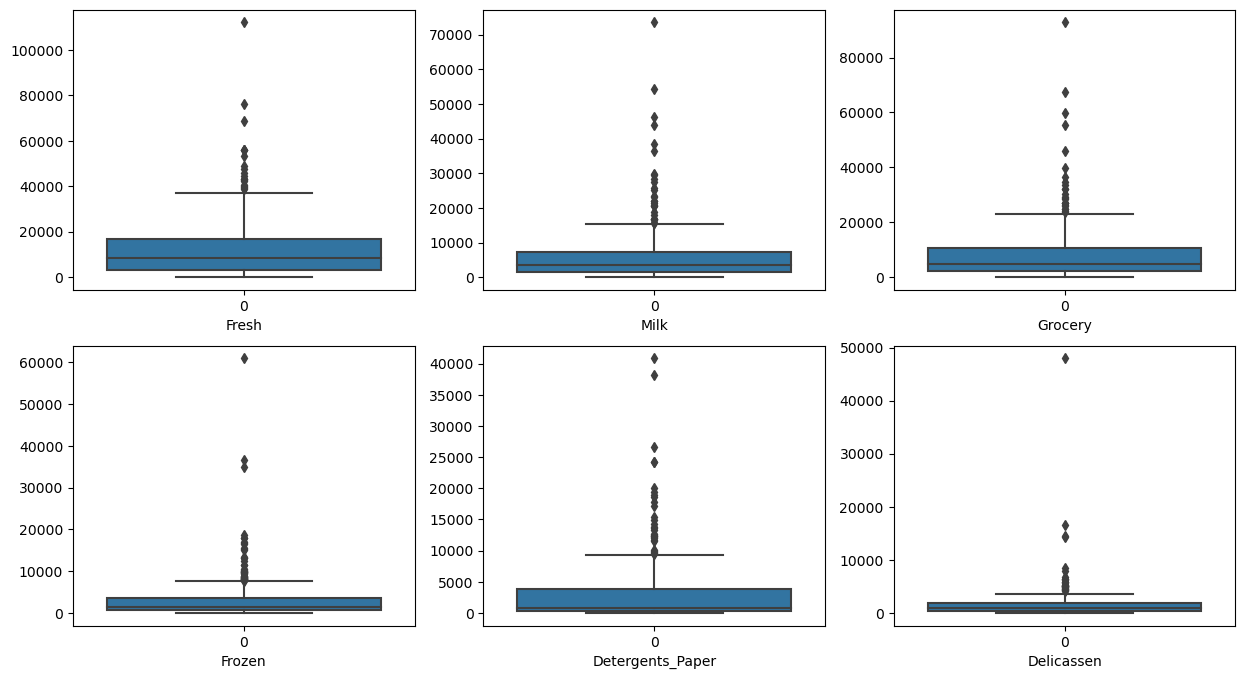

In [18]:
# Check outliers by using boxplot on the numeric_columns

fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (15,8))
plt.sca(axes[0, 0])
sns.boxplot(customers['Fresh'])
plt.xlabel('Fresh')
plt.sca(axes[0, 1])
sns.boxplot(customers['Milk'])
plt.xlabel('Milk')
plt.sca(axes[0, 2])
sns.boxplot(customers['Grocery'])
plt.xlabel('Grocery')
plt.sca(axes[1, 0])
sns.boxplot(customers['Frozen'])
plt.xlabel('Frozen')
plt.sca(axes[1, 1])
sns.boxplot(customers['Detergents_Paper'])
plt.xlabel('Detergents_Paper')
plt.sca(axes[1, 2])
sns.boxplot(customers['Delicassen'])
plt.xlabel('Delicassen')
plt.show()

In [19]:
'''For every column, there are some outliers, which could worth checking Pareto principle for each numerical column'''

'For every column, there are some outliers, which could worth checking Pareto principle for each numerical column'

In [20]:
for column in numeric_columns:
    # Step 1: Sort the data in descending order
    sorted_data = np.sort(customers[column])[::-1]

    # Step 2: Calculate the Percentage of the top 20%
    percentage = np.sum(sorted_data[:int(0.2 * len(sorted_data) + 1)]) / np.sum(sorted_data)

    # Step 3: Set a Threshold
    threshold = 0.8

    # Step 4: Calculate the 20% of data on the top

    # Step 4: Check for Pareto Principle
    if percentage >= threshold:
        print(f"Pareto Principle holds for {column}", percentage)
    else:
        print(f"Pareto Principle does not hold for {column}", percentage)

Pareto Principle does not hold for Fresh 0.5302987747841862
Pareto Principle does not hold for Milk 0.5637798943442036
Pareto Principle does not hold for Grocery 0.5603382189596754
Pareto Principle does not hold for Frozen 0.6270876336329672
Pareto Principle does not hold for Detergents_Paper 0.7007107268406453
Pareto Principle does not hold for Delicassen 0.5770609425837963


# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [21]:
# Your code here
# One-hot encoding on the first two columns
customers_encoded = pd.get_dummies(customers, columns=['Channel', 'Region'], drop_first=True)
customers_encoded.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Channel_2,Region_2,Region_3
0,12669,9656,7561,214,2674,1338,True,False,True
1,7057,9810,9568,1762,3293,1776,True,False,True
2,6353,8808,7684,2405,3516,7844,True,False,True
3,13265,1196,4221,6404,507,1788,False,False,True
4,22615,5410,7198,3915,1777,5185,True,False,True


In [22]:
#Drop "Grocery" as it has very high collinearity with "Detergents_Paper"
customers_encoded.drop(columns=['Grocery'], inplace=True)

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

In [23]:
# Your import here:

from sklearn.preprocessing import StandardScaler

# Your code here:
scaler= StandardScaler()
scaler.fit(customers_encoded)
customers_scale =scaler.transform(customers_encoded)


In [24]:
customers_scale_df = pd.DataFrame(customers_scale, columns=customers_encoded.columns)
customers_scale_df.head()

,Fresh,Milk,Frozen,Detergents_Paper,Delicassen,Channel_2,Region_2,Region_3
0,0.052933,0.523568,-0.589367,-0.043569,-0.066339,1.448652,-0.345822,0.626422
1,-0.391302,0.544458,-0.270136,0.086407,0.089151,1.448652,-0.345822,0.626422
2,-0.447029,0.408538,-0.137536,0.133232,2.243293,1.448652,-0.345822,0.626422
3,0.100111,-0.624020,0.687144,-0.498588,0.093411,-0.690297,-0.345822,0.626422
4,0.840239,-0.052396,0.173859,-0.231918,1.299347,1.448652,-0.345822,0.626422


# Challenge 4 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [25]:
# Your code here:
from sklearn import cluster
from sklearn.metrics import silhouette_score
kmeans = cluster.KMeans(n_clusters=3, random_state=42)
kmeans.fit(customers_scale_df)
pred = kmeans.predict(customers_scale_df)




c:\Users\ruoxi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [26]:
print("Model 1 Silhouette Score: {}".format(silhouette_score(customers_scale_df, pred, metric='euclidean')))

Model 1 Silhouette Score: 0.32519163328815265


c:\Users\ruoxi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\ruoxi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\ruoxi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\ruoxi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

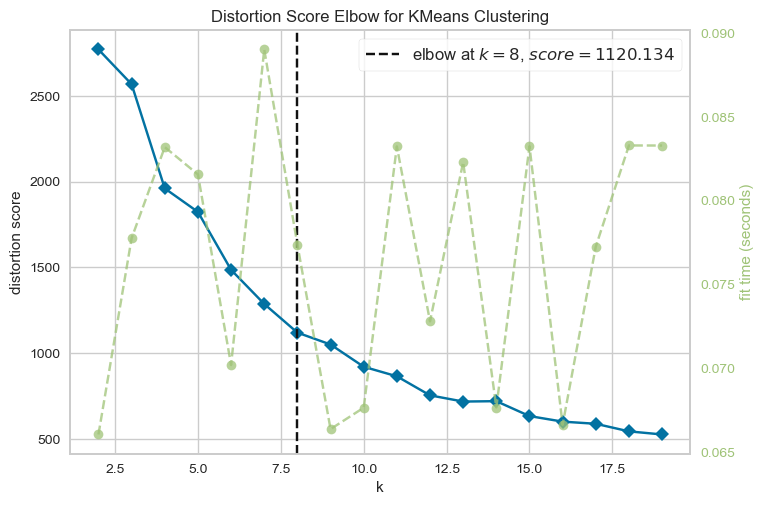

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [27]:
# To determine how many clusters are better
!pip install yellowbrick
from yellowbrick.cluster import KElbowVisualizer

model = cluster.KMeans()
visualizer = KElbowVisualizer(model, k=(2,20))
visualizer.fit(customers_scale_df)
visualizer.poof()

In [28]:
# Try with 7 clusters
kmeans = cluster.KMeans(n_clusters=7, random_state=42)
kmeans.fit(customers_scale_df)
pred = kmeans.predict(customers_scale_df)
print("Model 2 Silhouette Score: {}".format(silhouette_score(customers_scale_df, pred, metric='euclidean')))

Model 2 Silhouette Score: 0.3520344278435744


c:\Users\ruoxi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Count the values in `labels`.

In [29]:
# Your code here:

customers['Labels'] = pd.Series(kmeans.labels_).astype(int)
customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Labels
0,2,3,12669,9656,7561,214,2674,1338,0
1,2,3,7057,9810,9568,1762,3293,1776,0
2,2,3,6353,8808,7684,2405,3516,7844,0
3,1,3,13265,1196,4221,6404,507,1788,5
4,2,3,22615,5410,7198,3915,1777,5185,0


# Challenge 5 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [30]:
# Your code here
dbscan = cluster.DBSCAN(eps=0.5, min_samples=5) 
dbscan.fit(customers_scale_df)

# Add the cluster labels to the original DataFrame
customers['Labels_DBSCAN'] = dbscan.labels_
customers.head()


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Labels,Labels_DBSCAN
0,2,3,12669,9656,7561,214,2674,1338,0,0
1,2,3,7057,9810,9568,1762,3293,1776,0,0
2,2,3,6353,8808,7684,2405,3516,7844,0,-1
3,1,3,13265,1196,4221,6404,507,1788,5,2
4,2,3,22615,5410,7198,3915,1777,5185,0,-1


Count the values in `labels_DBSCAN`.

In [31]:
# Your code here
customers['Labels_DBSCAN'].value_counts()

Labels_DBSCAN
-1    203
 2    144
 0     35
 5     23
 7     14
 1      7
 6      6
 3      5
 4      3
Name: count, dtype: int64

# Challenge 6 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

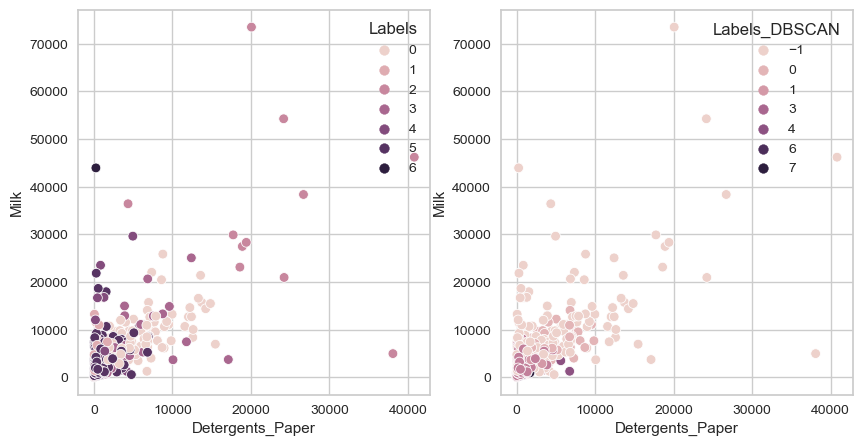

In [32]:
# Your code here:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
plt.sca(axes[0])
sns.scatterplot(data=customers, x='Detergents_Paper', y='Milk', hue='Labels')
plt.xlabel='Dettergents_Paper'
plt.ylabel='Milk'

plt.sca(axes[1])
sns.scatterplot(data=customers, x='Detergents_Paper', y='Milk', hue='Labels_DBSCAN')
plt.xlabel='Dettergents_Paper'
plt.ylabel='Milk'

plt.show()


Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

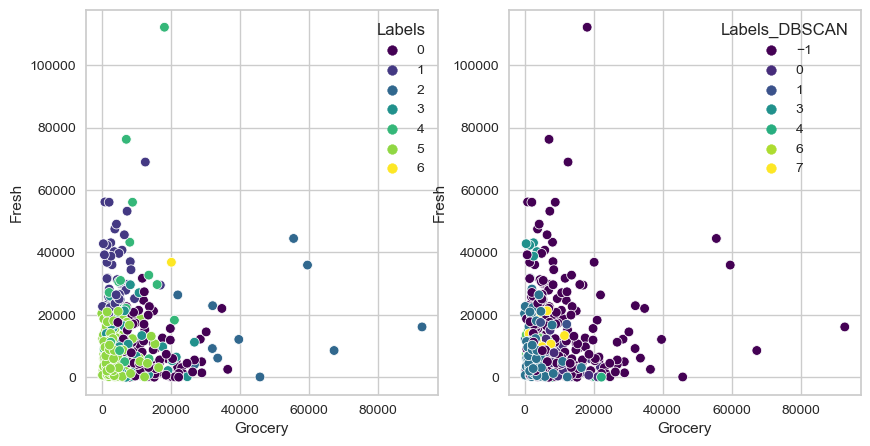

In [33]:
# Your code here:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

plt.sca(axes[0])
sns.scatterplot(data=customers, x='Grocery', y='Fresh', hue='Labels', palette='viridis')
plt.xlabel='Grocery'
plt.ylabel='Fresh'

plt.sca(axes[1])
sns.scatterplot(data=customers, x='Grocery', y='Fresh', hue='Labels_DBSCAN', palette='viridis')
plt.xlabel='Grocery'
plt.ylabel='Fresh'

plt.show()

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

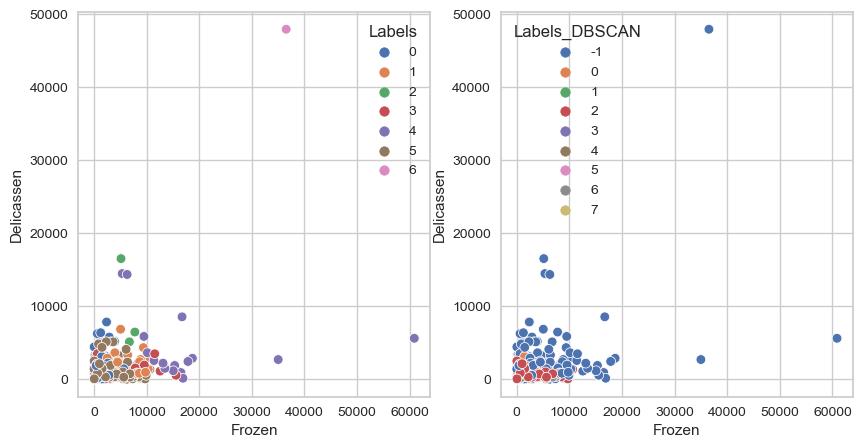

In [34]:
# Your code here:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

plt.sca(axes[0])
sns.scatterplot(data=customers, x='Frozen', y='Delicassen', hue='Labels', palette='deep')
plt.xlabel='Frozen'
plt.ylabel='Delicassen'

plt.sca(axes[1])
sns.scatterplot(data=customers, x='Frozen', y='Delicassen', hue='Labels_DBSCAN', palette='deep')
plt.xlabel='Frozen'
plt.ylabel='Delicassen'


plt.show()

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [35]:
# Your code here:
customers.groupby('Labels').agg('mean').reset_index()

,Labels,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Labels_DBSCAN
0,0,2.000000,2.711712,7820.279279,8655.225225,14024.540541,1512.927928,5895.297297,1596.378378,-0.423423
1,1,1.044444,2.555556,33953.777778,3643.666667,4264.311111,3909.422222,593.888889,1651.688889,-0.088889
2,2,2.000000,2.545455,16911.090909,34864.363636,46126.181818,3245.454545,23008.090909,4177.363636,-1.000000
3,3,1.400000,2.000000,9409.755556,4830.666667,7830.000000,2869.600000,2976.377778,1059.600000,1.488889
4,4,1.000000,2.611111,30800.722222,8141.833333,8225.000000,17429.500000,1172.944444,4181.277778,-1.000000
5,5,1.000000,2.559809,8054.732057,3034.789474,3454.478469,2357.387560,853.473684,969.282297,1.827751
6,6,1.000000,3.000000,36847.000000,43950.000000,20170.000000,36534.000000,239.000000,47943.000000,-1.000000


In [36]:
customers.groupby('Labels_DBSCAN').agg('mean').reset_index()

,Labels_DBSCAN,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Labels
0,-1,1.477833,2.364532,15470.502463,9089.201970,11894.093596,4384.403941,4606.566502,2338.689655,2.172414
1,0,2.000000,3.000000,4068.971429,8220.371429,12157.371429,843.485714,5262.514286,1425.771429,0.000000
2,1,2.000000,3.000000,13078.571429,3464.428571,7219.142857,790.571429,3260.142857,315.428571,0.000000
3,2,1.000000,3.000000,8814.729167,2109.006944,2894.555556,2143.854167,625.451389,750.076389,4.805556
4,3,1.000000,3.000000,41446.600000,1421.200000,2167.600000,1276.400000,416.200000,784.800000,1.000000
5,4,2.000000,3.000000,80.000000,2458.666667,16894.000000,413.666667,5413.000000,331.000000,0.000000
6,5,1.000000,1.000000,9918.217391,1769.347826,2364.391304,1600.739130,345.173913,670.260870,5.000000
7,6,1.000000,1.000000,6823.000000,1943.000000,2372.666667,6780.333333,386.500000,613.666667,5.000000
8,7,1.000000,2.000000,11414.571429,1625.214286,4361.857143,2337.357143,505.142857,860.928571,3.000000


Which algorithm appears to perform better?

In [37]:
# Your observations here
'''It feels Kmean gives a better result, because DBSCAN lebels a log of data as noise'''

# Bonus Challenge 1 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [46]:
# Your code here
# We have tried 3 clusters, 7 clusters, and now we try 5 clusters
kmeans = cluster.KMeans(n_clusters=5, random_state=42)
kmeans.fit(customers_scale_df)
pred = kmeans.predict(customers_scale_df)
print("Model 2 Silhouette Score: {}".format(silhouette_score(customers_scale_df, pred, metric='euclidean')))

Model 2 Silhouette Score: 0.3762679894209087


c:\Users\ruoxi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [47]:
# Assign the label to the original dataframe
customers['Labels_next'] = kmeans.labels_
customers.groupby('Labels_next').agg('mean').reset_index()

,Labels_next,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Labels,Labels_DBSCAN
0,0,2.000000,2.692308,8037.658120,9354.085470,14876.991453,1588.316239,6460.222222,1661.196581,0.094017,-0.452991
1,1,1.000000,2.526786,9273.665179,3148.102679,3538.602679,2281.361607,822.776786,996.035714,4.709821,1.705357
2,2,1.833333,3.000000,30445.000000,48782.666667,47042.000000,9122.833333,19390.833333,12799.166667,2.666667,-1.000000
3,3,1.413043,2.000000,9391.391304,4833.913043,9122.782609,2810.065217,3739.978261,1062.978261,2.978261,1.434783
4,4,1.021277,2.723404,35058.510638,5014.851064,5604.404255,10016.851064,836.702128,2718.702128,2.255319,-0.446809


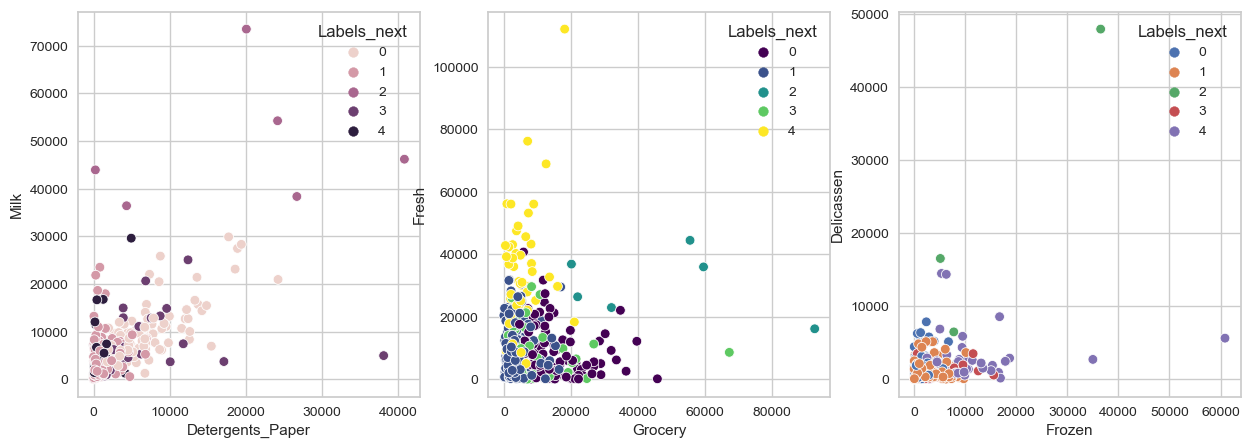

In [48]:

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

plt.sca(axes[0])
sns.scatterplot(data=customers, x='Detergents_Paper', y='Milk', hue='Labels_next')
plt.xlabel='Grocery'
plt.ylabel='Fresh'

plt.sca(axes[1])
sns.scatterplot(data=customers, x='Grocery', y='Fresh', hue='Labels_next', palette='viridis')
plt.xlabel='Grocery'
plt.ylabel='Fresh'

plt.sca(axes[2])
sns.scatterplot(data=customers, x='Frozen', y='Delicassen', hue='Labels_next', palette='deep')
plt.xlabel='Frozen'
plt.ylabel='Delicassen'
plt.show()

In [39]:
# Your comment here
# I actually feel 5 clusters look better? 

# Bonus Challenge 2 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [55]:
# Your code here
# I acutually tested it before, but I'll do it again
dbscan = cluster.DBSCAN(eps=1, min_samples=5) 
dbscan.fit(customers_scale_df)

# Add the cluster labels to the original DataFrame
customers['Labels_DBSCAN_Next'] = dbscan.labels_
customers.head()


,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Labels,Labels_DBSCAN,Labels_next,Labels_DBSCAN_Next
0,2,3,12669,9656,7561,214,2674,1338,0,0,0,0
1,2,3,7057,9810,9568,1762,3293,1776,0,0,0,0
2,2,3,6353,8808,7684,2405,3516,7844,0,-1,0,-1
3,1,3,13265,1196,4221,6404,507,1788,5,2,1,1
4,2,3,22615,5410,7198,3915,1777,5185,0,-1,0,0


In [56]:
customers.groupby('Labels_DBSCAN_Next').agg('mean').reset_index()

,Labels_DBSCAN_Next,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Labels,Labels_DBSCAN,Labels_next
0,-1,1.523077,2.4,22376.907692,14298.784615,17167.861538,7933.230769,6541.046154,4157.015385,2.292308,-1.000000,2.261538
1,0,2.000000,3.0,8246.244186,8066.209302,12906.069767,1322.453488,5603.941860,1352.476744,0.000000,-0.255814,0.000000
2,1,1.000000,3.0,11640.394737,2797.531579,3402.668421,2579.900000,748.384211,1016.752632,4.405263,1.378947,1.347368
3,2,2.000000,1.0,3390.416667,10059.333333,18659.833333,1504.583333,8411.916667,1190.166667,0.000000,-1.000000,0.000000
4,3,1.000000,1.0,10004.725490,2989.862745,3616.235294,2348.941176,976.254902,883.235294,4.529412,2.529412,1.000000
5,4,2.000000,2.0,6035.900000,7511.400000,11544.900000,983.600000,5559.600000,710.800000,3.000000,-1.000000,3.000000
6,5,1.000000,2.0,11288.269231,1823.153846,3939.500000,3245.807692,470.346154,954.076923,3.000000,3.307692,3.000000


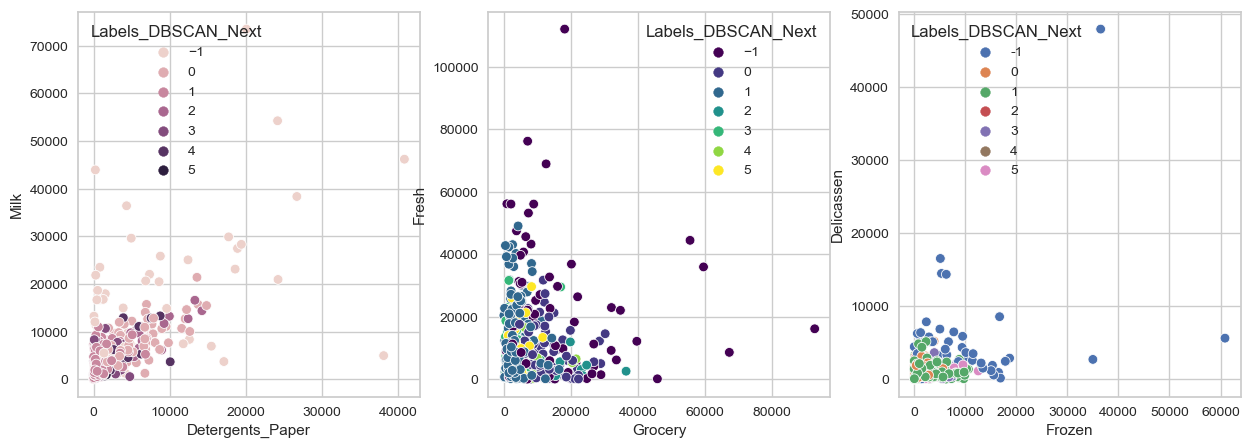

In [57]:

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

plt.sca(axes[0])
sns.scatterplot(data=customers, x='Detergents_Paper', y='Milk', hue='Labels_DBSCAN_Next')
plt.xlabel='Grocery'
plt.ylabel='Fresh'

plt.sca(axes[1])
sns.scatterplot(data=customers, x='Grocery', y='Fresh', hue='Labels_DBSCAN_Next', palette='viridis')
plt.xlabel='Grocery'
plt.ylabel='Fresh'

plt.sca(axes[2])
sns.scatterplot(data=customers, x='Frozen', y='Delicassen', hue='Labels_DBSCAN_Next', palette='deep')
plt.xlabel='Frozen'
plt.ylabel='Delicassen'
plt.show()

In [41]:
# Your comment here
'''There are still too many data points regarded as noise no matter how the min_samples is changed. I don't like this result'''